# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from keras.callbacks import ModelCheckpoint
from tqdm import tqdm
import os

from sklearn.model_selection import train_test_split
from keras.layers import Dense,BatchNormalization,Dropout
from keras.initializers import glorot_normal,he_normal

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#to see the dataset in kaggle wich startrs with amazon
#!kaggle datasets list -s Amazon

#to download and save in google drive
#!kaggle datasets download --force snap/amazon-fine-food-reviews 

In [0]:
#unzip in specified folder
#import os
#os.chdir('drive/My Drive/kaggle/amazon')  #change dir
#!mkdir Amz_unzip  #create a directory named Amz_unzip/
#!unzip -q amazon-fine-food-reviews.zip -d Amz_unzip/  #unzip data in Amz_unzip/

# [1]. Reading Data

In [0]:
# using the SQLite Table to read data.
con = sqlite3.connect('/content/drive/My Drive/kaggle/amazon/Amz_unzip/database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 300000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (300000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(228569, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

76.18966666666667

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(228567, 10)


1    192377
0     36190
Name: Score, dtype: int64

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
final['preprocessed_reviews'] = preprocessed_reviews

100%|██████████| 228567/228567 [01:35<00:00, 2400.96it/s]


In [0]:
y = final["Score"]
x = final["preprocessed_reviews"]

# [4] Featurization

In [0]:
#train test split
from sklearn.model_selection import train_test_split
x_train,X_val,y_train,Y_val = train_test_split(x,y,test_size =0.3,stratify =y,random_state=0 )
x_cv,x_test,y_cv,y_test = train_test_split(X_val,Y_val,test_size =0.2,stratify =Y_val,random_state=0 )

In [0]:
print("Data points of X_train : {} \nData points of X_cv : {}\nData points of X_test : {}".format(x_train.shape[0],x_cv.shape[0] ,x_test.shape[0]))

Data points of X_train : 159996 
Data points of X_cv : 54856
Data points of X_test : 13715


## [4.1] selecting important words

In [0]:
#will see the idf values and select the words which have idf value which is not very low and not very high
tf_idf_vect = TfidfVectorizer()
tf_idf_vect.fit(x_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])

some sample features(unique words in the corpus) ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaarrrrrggghhh', 'aaaaaahhhhhyaaaaaa', 'aaaaah']


Text(0, 0.5, 'num of words')

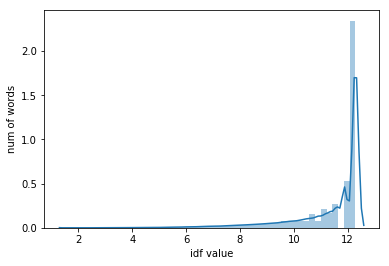

In [0]:
import seaborn
seaborn.distplot(tf_idf_vect.idf_, axlabel=("idf value"), label="idf value vs Number of words")
plt.ylabel("num of words")

In [0]:
#selecting 5000 top words with are not very rare and have high ifd value
max_feat = 5000
tf_idf_vect = TfidfVectorizer(min_df=6,max_features=max_feat)
final_tf_idf_train = tf_idf_vect.fit_transform(x_train)
print("sample featuers",tf_idf_vect.get_feature_names()[:10])

sample featuers ['ability', 'able', 'absolute', 'absolutely', 'absorb', 'absorbed', 'acai', 'accept', 'acceptable', 'access']


In [0]:
#storing words in list in the sorted order of count (decresing)
encoding_lis=tf_idf_vect.get_feature_names()

In [0]:
#removing words which are not in top 5000 words from all train document 
train_removed = []
for sentence in x_train:
   train_removed.append(list(filter(lambda x: x in encoding_lis,sentence.split(" "))))
    
#removing words which are not in top 5000 words from all cv document 
cv_removed = []
for sentence in x_cv:
   cv_removed.append(list(filter(lambda x: x in encoding_lis,sentence.split(" "))))
    
#removing words which are not in top 5000 words from all train document 
test_removed = []
for sentence in x_test:
   test_removed.append(list(filter(lambda x: x in encoding_lis,sentence.split(" "))))

In [0]:
#encoding the words with the index they are sorted
train_ecoded_ls = []
for sentance_as_list in train_removed:
  train_ecoded_ls.append(list(map(lambda x: encoding_lis.index(x)+1,sentance_as_list)))

#encoding the words with the index they are sorted
cv_ecoded_ls = []
for sentance_as_list in cv_removed:
  cv_ecoded_ls.append(list(map(lambda x: encoding_lis.index(x)+1,sentance_as_list)))
  
#encoding the words with the index they are sorted
test_ecoded_ls = []
for sentance_as_list in test_removed:
  test_ecoded_ls.append(list(map(lambda x: encoding_lis.index(x)+1,sentance_as_list)))

In [0]:
# Credits: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
# LSTM for sequence classification in the Amazon dataset
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)

In [0]:
# truncate and/or pad input sequences
max_review_length = 600
X_train = sequence.pad_sequences(train_ecoded_ls, maxlen=max_review_length)
X_cv = sequence.pad_sequences(cv_ecoded_ls, maxlen=max_review_length)
X_test = sequence.pad_sequences(test_ecoded_ls, maxlen=max_review_length)

print(X_train.shape)
print((X_train[1]))

(159996, 600)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   

In [0]:
pd.DataFrame(X_train).to_csv("/content/drive/My Drive/kaggle/amazon/Amz_unzip/X_train.csv")
pd.DataFrame(X_cv).to_csv("/content/drive/My Drive/kaggle/amazon/Amz_unzip/X_cv.csv")
pd.DataFrame(X_test).to_csv("/content/drive/My Drive/kaggle/amazon/Amz_unzip/X_test.csv")

# 5 Building of Models

# 5.1 Single layer of LSTM 

In [0]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(max_feat+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,333
Trainable params: 213,333
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
#Training model
epochs = 10
history = model.fit(X_train, y_train, nb_epoch=epochs, batch_size=248,validation_data = (X_cv,y_cv))

Train on 159996 samples, validate on 54856 samples
Epoch 1/10
159996/159996 [==============================] - 610s 4ms/step - loss: 0.2410 - acc: 0.9065 - val_loss: 0.1910 - val_acc: 0.9251
Epoch 2/10
159996/159996 [==============================] - 613s 4ms/step - loss: 0.1815 - acc: 0.9296 - val_loss: 0.1875 - val_acc: 0.9260
Epoch 3/10
159996/159996 [==============================] - 616s 4ms/step - loss: 0.1695 - acc: 0.9342 - val_loss: 0.1798 - val_acc: 0.9298
Epoch 4/10
159996/159996 [==============================] - 616s 4ms/step - loss: 0.1575 - acc: 0.9394 - val_loss: 0.1753 - val_acc: 0.9312
Epoch 5/10
159996/159996 [==============================] - 613s 4ms/step - loss: 0.1452 - acc: 0.9443 - val_loss: 0.1773 - val_acc: 0.9305
Epoch 6/10
159996/159996 [==============================] - 608s 4ms/step - loss: 0.1338 - acc: 0.9496 - val_loss: 0.1816 - val_acc: 0.9322
Epoch 7/10
159996/159996 [==============================] - 615s 4ms/step - loss: 0.1240 - acc: 0.9528 - val_

In [0]:
# Final evaluation of the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20217405816650807
Test accuracy: 0.9310244258198476


In [0]:
#function to plot graph
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

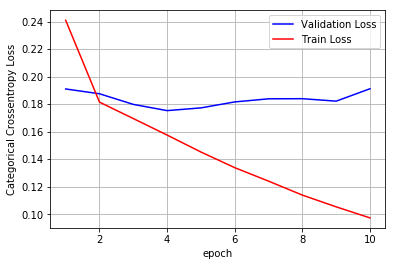

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

The model is getting overfitted as we can see the difference between train and test loss is we increase as the the epoch increases.so we will try Neural Network with multi Layered LSTM and see the results below.

# 5.2 Multi Layered LSTM

In [0]:
# Credits: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
# LSTM for sequence classification in the Amazon dataset
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)

In [0]:
X_train = pd.read_csv('/content/drive/My Drive/kaggle/amazon/Amz_unzip/X_train.csv').iloc[:,1:]
X_test = pd.read_csv('/content/drive/My Drive/kaggle/amazon/Amz_unzip/X_test.csv').iloc[:,1:]
X_cv = pd.read_csv('/content/drive/My Drive/kaggle/amazon/Amz_unzip/X_cv.csv').iloc[:,1:]

In [0]:
max_feat = 5000
max_review_length = 600
embedding_vecor_length = 32

from keras.callbacks import ModelCheckpoint

#initilizing model
model_2 = Sequential()

#embedding layer which gives 64 dim vector for each batch 
model_2.add(Embedding(max_feat+1, embedding_vecor_length, input_length=max_review_length))

#LSTM layer which takes 3D input and returnes output for each time step which can be passed to next layer LSTM
#this is done by setting return_sequences=True 
#reference "https://machinelearningmastery.com/stacked-long-short-term-memory-networks/"
model_2.add(LSTM(50,activation = 'relu',kernel_initializer = 'he_normal',return_sequences=True))

#second layer of LSTM
model_2.add(LSTM(30,activation = 'relu',kernel_initializer = 'he_normal'))

#dense layer of size 300
model_2.add(Dense(300,activation= 'relu',kernel_initializer = 'he_normal'))

#dense layer of size 1
model_2.add(Dense(1,activation= 'relu'))

#callback
Check_point =ModelCheckpoint('/content/drive/My Drive/kaggle/amazon/Amz_unzip/Amazon_best_Multi_LSTM_Model2.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='min', period=3)

#compiling model
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


print(model_2.summary())            







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 600, 50)           16600     
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               9300      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 301       
Total params: 195,953
Trainable params: 195,953
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
#Training model
epochs = 10
history = model_2.fit(X_train, y_train, nb_epoch=epochs, batch_size=482,validation_data = (X_cv,y_cv),callbacks=[Check_point])

Train on 159996 samples, validate on 54856 samples
Epoch 1/10
159996/159996 [==============================] - 923s 6ms/step - loss: 0.4720 - acc: 0.7927 - val_loss: 0.3195 - val_acc: 0.8717
Epoch 2/10
159996/159996 [==============================] - 904s 6ms/step - loss: 0.2995 - acc: 0.8676 - val_loss: 0.2844 - val_acc: 0.8707
Epoch 3/10
159996/159996 [==============================] - 919s 6ms/step - loss: 1.8848 - acc: 0.3033 - val_loss: 1.8911 - val_acc: 0.1583
Epoch 4/10
159996/159996 [==============================] - 934s 6ms/step - loss: 1.6843 - acc: 0.1583 - val_loss: 1.5201 - val_acc: 0.1583
Epoch 5/10
159996/159996 [==============================] - 953s 6ms/step - loss: 1.4039 - acc: 0.1583 - val_loss: 1.3006 - val_acc: 0.1583
Epoch 6/10
159996/159996 [==============================] - 928s 6ms/step - loss: 1.2167 - acc: 0.1583 - val_loss: 1.1392 - val_acc: 0.1583
Epoch 7/10
159996/159996 [==============================] - 922s 6ms/step - loss: 1.0726 - acc: 0.1583 - val_

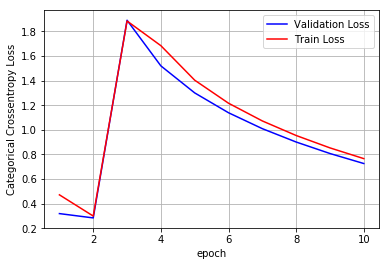

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

As we can see that the model is doing good,the loss is getting low and the difference between train and test loss is very low ,we can load the model again and train for 10 more epochs .

In [0]:
# Loading same model and train 
from keras.models import load_model
model_2 = load_model('/content/drive/My Drive/kaggle/amazon/Amz_unzip/Amazon_best_Multi_LSTM_Model2.h5')
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 600, 50)           16600     
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               9300      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 301       
Total params: 195,953
Trainable params: 195,953
Non-trainable params: 0
_________________________________________________________________


In [0]:
#callback
Check_point =ModelCheckpoint('/content/drive/My Drive/kaggle/amazon/Amz_unzip/Amazon_best_Multi_LSTM_Model2_retrain.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='min', period=4)
#Training model
epochs = 10
history = model_2.fit(X_train, y_train, nb_epoch=epochs, batch_size=482,validation_data = (X_cv,y_cv),callbacks=[Check_point])


Train on 159996 samples, validate on 54856 samples
Epoch 1/10
159996/159996 [==============================] - 852s 5ms/step - loss: 0.7663 - acc: 0.1583 - val_loss: 0.7264 - val_acc: 0.1583
Epoch 2/10
159996/159996 [==============================] - 845s 5ms/step - loss: 0.6902 - acc: 0.5329 - val_loss: 0.6554 - val_acc: 0.8417
Epoch 3/10
159996/159996 [==============================] - 837s 5ms/step - loss: 0.6241 - acc: 0.8417 - val_loss: 0.5941 - val_acc: 0.8417
Epoch 4/10
159996/159996 [==============================] - 840s 5ms/step - loss: 0.5675 - acc: 0.8417 - val_loss: 0.5424 - val_acc: 0.8417
Epoch 5/10
159996/159996 [==============================] - 846s 5ms/step - loss: 0.5209 - acc: 0.8417 - val_loss: 0.5010 - val_acc: 0.8417
Epoch 6/10
159996/159996 [==============================] - 843s 5ms/step - loss: 0.4848 - acc: 0.8417 - val_loss: 0.4704 - val_acc: 0.8417
Epoch 7/10
159996/159996 [==============================] - 842s 5ms/step - loss: 0.4598 - acc: 0.8417 - val_

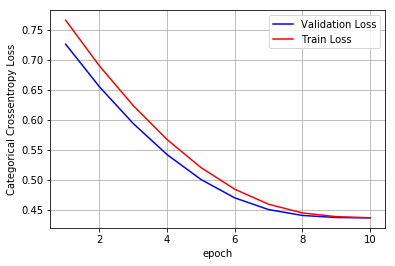

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

Even here the model is doing good the loss is decreasing and it does not seem over fitting or underfitting .
As you see in the graph at the very end the loss is no more decresing ,so their is a chance that the model reached the saturation point ,where no more loss reduction might happen .
to confirm it we will run the mosel for some more epoch

In [0]:
from keras.models import load_model
model_2 = load_model('/content/drive/My Drive/kaggle/amazon/Amz_unzip/Amazon_best_Multi_LSTM_Model2_retrain.h5')
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 600, 50)           16600     
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               9300      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 301       
Total params: 195,953
Trainable params: 195,953
Non-trainable params: 0
_________________________________________________________________


In [0]:
#callback
Check_point =ModelCheckpoint('/content/drive/My Drive/kaggle/amazon/Amz_unzip/Amazon_best_Multi_LSTM_Model2_retrain_2.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='min', period=4)
#Training model
epochs = 15
history = model_2.fit(X_train, y_train, nb_epoch=epochs, batch_size=482,validation_data = (X_cv,y_cv),callbacks=[Check_point])


Train on 159996 samples, validate on 54856 samples
Epoch 1/15
159996/159996 [==============================] - 850s 5ms/step - loss: 0.4391 - acc: 0.8417 - val_loss: 0.4377 - val_acc: 0.8417
Epoch 2/15
159996/159996 [==============================] - 845s 5ms/step - loss: 0.4373 - acc: 0.8417 - val_loss: 0.4370 - val_acc: 0.8417
Epoch 3/15
159996/159996 [==============================] - 849s 5ms/step - loss: 0.4369 - acc: 0.8417 - val_loss: 0.4369 - val_acc: 0.8417
Epoch 4/15
159996/159996 [==============================] - 848s 5ms/step - loss: 0.4369 - acc: 0.8417 - val_loss: 0.4369 - val_acc: 0.8417
Epoch 5/15
159996/159996 [==============================] - 845s 5ms/step - loss: 0.4369 - acc: 0.8417 - val_loss: 0.4369 - val_acc: 0.8417
Epoch 6/15
159996/159996 [==============================] - 840s 5ms/step - loss: 0.4369 - acc: 0.8417 - val_loss: 0.4369 - val_acc: 0.8417
Epoch 7/15
159996/159996 [==============================] - 837s 5ms/step - loss: 0.4369 - acc: 0.8417 - val_

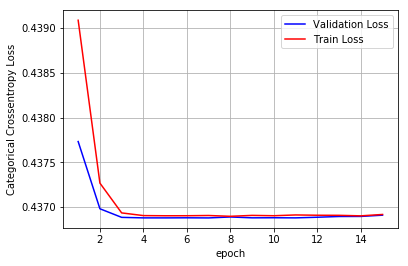

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

Here we can see that the loss does not decress after certain epochs and it remains constant.The model did a good job but not as comapred to single LSTM layer .The loss here is bit high than
single LSTM layer model.so we will try some deap Network

In [0]:
# Final evaluation of the model
score = model_2.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.43698130899478693
Test accuracy: 0.8416332483074329


# 5.3 Multi Layered LSTM With Previous Network Trained Weight

In [0]:
#Deeper neural network with weight initilization from 
max_feat = 5000
max_review_length = 600
embedding_vecor_length = 32

from keras.callbacks import ModelCheckpoint

#initilizing model
model_3 = Sequential()

#embedding layer which gives 32 dim vector for each batch 
model_3.add(Embedding(max_feat+1, embedding_vecor_length, input_length=max_review_length,name = 'embedding_1'))

#LSTM layer which takes 3D input and returnes output for each time step which can be passed to next layer LSTM
#this is done by setting return_sequences=True 
#reference "https://machinelearningmastery.com/stacked-long-short-term-memory-networks/"
model_3.add(LSTM(50,activation = 'relu',return_sequences=True,name='lstm_1'))

#second layer of LSTM
model_3.add(LSTM(30,activation = 'relu',name = 'lstm_2'))

#dense layer of size 300
model_3.add(Dense(300,activation= 'relu',name = 'new_connection1'))
model_3.add(BatchNormalization())

#dense layer of size 100
model_3.add(Dense(100,activation= 'relu',kernel_initializer = 'he_normal',name = 'new_connection2'))
model_3.add(Dropout(0.25))

#dense layer of size 1
model_3.add(Dense(1,activation= 'relu',name = 'new_connection3'))

#loading weight of first layer of single layered LSMT
model_3.load_weights('/content/drive/My Drive/kaggle/amazon/Amz_unzip/Amazon_best_Multi_LSTM_retrain.h5',by_name=True)

#callback
Check_point =ModelCheckpoint('/content/drive/My Drive/kaggle/amazon/Amz_unzip/Amazon_best_Multi_LSTM_model3.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='min', period=2)

#compiling model
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_3.summary())            






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 600, 50)           16600     
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                9720      
_________________________________________________________________
new_connection1 (Dense)      (None, 300)               9300      
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_____________________________________

In [0]:
epochs = 5
model_3.fit(X_train, y_train, nb_epoch=epochs, batch_size=482,validation_data = (X_cv,y_cv),callbacks=[Check_point])

Train on 159996 samples, validate on 54856 samples
Epoch 1/5
159996/159996 [==============================] - 863s 5ms/step - loss: 13.5660 - acc: 0.1583 - val_loss: 13.5662 - val_acc: 0.1583
Epoch 2/5
159996/159996 [==============================] - 853s 5ms/step - loss: 13.5660 - acc: 0.1583 - val_loss: 13.5662 - val_acc: 0.1583
Epoch 3/5
159996/159996 [==============================] - 866s 5ms/step - loss: 13.5660 - acc: 0.1583 - val_loss: 13.5662 - val_acc: 0.1583
Epoch 4/5
159996/159996 [==============================] - 857s 5ms/step - loss: 13.5660 - acc: 0.1583 - val_loss: 13.5662 - val_acc: 0.1583
Epoch 5/5
159996/159996 [==============================] - 856s 5ms/step - loss: 13.5660 - acc: 0.1583 - val_loss: 13.5662 - val_acc: 0.1583


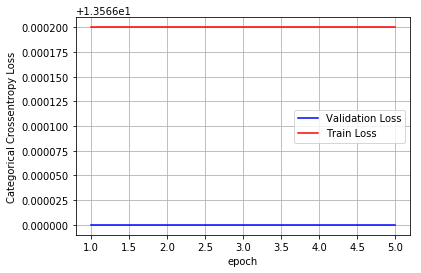

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = [13.5660,13.5660,13.5660,13.5660,13.5660]
ty = [13.5662,13.5662,13.5662,13.5662,13.5662]
plt_dynamic(x, vy, ty, ax)

Here the loss is not get decreasing and it is very high .it might be because the weight initialized made the model to stuck in some local minima or saddle point .Though ADAM optimizer make model to escape from local miniman and saddle point ,it might take lot of epoch .so lets try same model architucture with HE normal weight initilization .

In [0]:
# Final evaluation of the model
score = model_3.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 13.5660788917635029
Test accuracy: 0.158388917630


# 5.4 Multi Layered LSTM With He Normal Weight Initilization

In [0]:
#Deeper neural network with weight initilization from 
max_feat = 5000
max_review_length = 600
embedding_vecor_length = 32

from keras.callbacks import ModelCheckpoint

#initilizing model
model_4 = Sequential()

#embedding layer which gives 64 dim vector for each batch 
model_4.add(Embedding(max_feat+1, embedding_vecor_length, input_length=max_review_length,name = 'embedding_1'))

#LSTM layer which takes 3D input and returnes output for each time step which can be passed to next layer LSTM
#this is done by setting return_sequences=True 
#reference "https://machinelearningmastery.com/stacked-long-short-term-memory-networks/"
model_4.add(LSTM(50,activation = 'relu',return_sequences=True,name='lstm_1',kernel_initializer = 'he_normal'))

#second layer of LSTM
model_4.add(LSTM(30,activation = 'relu',name = 'lstm_2',kernel_initializer = 'he_normal'))

#dense layer of size 300
model_4.add(Dense(300,activation= 'relu',name = 'new_connection1',kernel_initializer = 'he_normal'))

#dense layer of size 100
model_4.add(Dense(100,activation= 'relu',kernel_initializer = 'he_normal',name = 'new_connection2'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.25))

#dense layer of size 1
model_4.add(Dense(1,activation= 'relu',name = 'new_connection3',kernel_initializer = 'he_normal'))

#callback
Check_point =ModelCheckpoint('/content/drive/My Drive/kaggle/amazon/Amz_unzip/Amazon_best_Multi_LSTM_model4.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='min', period=3)

#compiling model
model_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_4.summary())            

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 600, 50)           16600     
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                9720      
_________________________________________________________________
new_connection1 (Dense)      (None, 300)               9300      
_________________________________________________________________
new_connection2 (Dense)      (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)              

In [0]:
epochs = 15
history = model_4.fit(X_train, y_train, nb_epoch=epochs, batch_size=482,validation_data = (X_cv,y_cv),callbacks=[Check_point])

Train on 159996 samples, validate on 54856 samples
Epoch 1/15
159996/159996 [==============================] - 867s 5ms/step - loss: 0.3604 - acc: 0.8721 - val_loss: 0.5465 - val_acc: 0.8618
Epoch 2/15
159996/159996 [==============================] - 864s 5ms/step - loss: 0.3426 - acc: 0.8720 - val_loss: 2.5217 - val_acc: 1.8230e-04
Epoch 3/15
159996/159996 [==============================] - 872s 5ms/step - loss: 0.5793 - acc: 0.8270 - val_loss: 5.4205 - val_acc: 0.3835
Epoch 4/15
159996/159996 [==============================] - 868s 5ms/step - loss: 0.7475 - acc: 0.5895 - val_loss: 0.5424 - val_acc: 0.5994
Epoch 5/15
159996/159996 [==============================] - 871s 5ms/step - loss: 0.4364 - acc: 0.6932 - val_loss: 0.3946 - val_acc: 0.7822
Epoch 6/15
159996/159996 [==============================] - 866s 5ms/step - loss: 0.3852 - acc: 0.7653 - val_loss: 0.3492 - val_acc: 0.8014
Epoch 7/15
159996/159996 [==============================] - 870s 5ms/step - loss: 3.7873 - acc: 0.6491 - 

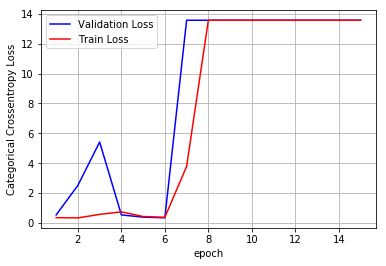

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

Here we can see the models loss started getting increased after few epoch it might be because the model would have escaped from local minima or saddle point and started moving ,But sadly again it got stuck in some higher loss point .so will leave this architecture and try 3 layer of LSTM. 

In [0]:
# Final evaluation of the model
score = model_4.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3481643864252773
Test accuracy: 0.8043018592868545


# 5.5 LSTM With deeper Neural Network and He Normal Weight Initilization

In [0]:
#Deeper neural network with weight initilization from 
max_feat = 5000
max_review_length = 600
embedding_vecor_length = 32

from keras.callbacks import ModelCheckpoint

#initilizing model
model_5 = Sequential()

#embedding layer which gives 32 dim vector for each batch 
model_5.add(Embedding(max_feat+1, embedding_vecor_length, input_length=max_review_length,name = 'embedding_1'))

#LSTM layer which takes 3D input and returnes output for each time step which can be passed to next layer LSTM
#this is done by setting return_sequences=True 
#reference "https://machinelearningmastery.com/stacked-long-short-term-memory-networks/"
model_5.add(LSTM(100,activation = 'relu',return_sequences=True,name='lstm_1',kernel_initializer = 'he_normal'))

#second layer of LSTM
model_5.add(LSTM(64,activation = 'relu',return_sequences=True,name='lstm_2',kernel_initializer = 'he_normal'))

#third layer of LSTM
model_5.add(LSTM(40,activation = 'relu',name = 'lstm_3',kernel_initializer = 'he_normal'))

#dense layer of size 200
model_5.add(Dense(200,activation= 'relu',name = 'new_connection1',kernel_initializer = 'he_normal'))
model_5.add(Dropout(0.25))

#dense layer of size 100
model_5.add(Dense(100,activation= 'relu',name = 'new_connection2',kernel_initializer = 'he_normal'))

#dense layer of size 64
model_5.add(Dense(64,activation= 'relu',kernel_initializer = 'he_normal',name = 'new_connection3'))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.25))

#dense layer of size 1
model_5.add(Dense(1,activation= 'relu',name = 'new_connection4',kernel_initializer = 'he_normal'))

#callback
Check_point =ModelCheckpoint('/content/drive/My Drive/kaggle/amazon/Amz_unzip/Amazon_best_Multi_LSTM_model5.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='min', period=3)

#compiling model
model_5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_5.summary())            

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 600, 64)           42240     
_________________________________________________________________
lstm_3 (LSTM)                (None, 40)                16800     
_________________________________________________________________
new_connection1 (Dense)      (None, 200)               8200      
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
new_connection2 (Dense)      (None, 100)              

In [0]:
epochs = 8
history = model_5.fit(X_train, y_train, nb_epoch=epochs, batch_size=482,validation_data = (X_cv,y_cv),callbacks=[Check_point])

Train on 159996 samples, validate on 54856 samples
Epoch 1/8
159996/159996 [==============================] - 1293s 8ms/step - loss: 3.2553 - acc: 0.5359 - val_loss: 1.9838 - val_acc: 0.8428
Epoch 2/8
159996/159996 [==============================] - 1288s 8ms/step - loss: 0.6746 - acc: 0.8179 - val_loss: 0.9588 - val_acc: 0.8498
Epoch 3/8
159996/159996 [==============================] - 1283s 8ms/step - loss: 0.4116 - acc: 0.8587 - val_loss: 0.3320 - val_acc: 0.8463
Epoch 4/8
159996/159996 [==============================] - 1294s 8ms/step - loss: 0.3951 - acc: 0.8601 - val_loss: 0.4611 - val_acc: 0.8728
Epoch 5/8
159996/159996 [==============================] - 1298s 8ms/step - loss: 0.4255 - acc: 0.8557 - val_loss: 0.4504 - val_acc: 0.8417
Epoch 6/8
159996/159996 [==============================] - 1274s 8ms/step - loss: 0.4695 - acc: 0.8412 - val_loss: 0.4431 - val_acc: 0.8417
Epoch 7/8
159996/159996 [==============================] - 1300s 8ms/step - loss: 0.4873 - acc: 0.8357 - val_

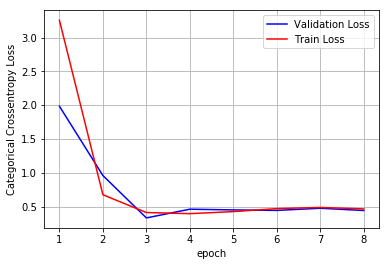

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [0]:
# Final evaluation of the model
score = model_5.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3436040930077841
Test accuracy: 0.8452788917635029


Its good to see that the model has performed well as loss got decreased and it attained saturation point ,but the loss is more when comapred to single layer LSTM.

# Result

In [0]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model Description","Train","CV","Test","Test Acc"]
x.add_row(["1 LSTM,1 Dense Layer", 0.0973,0.9319,0.202,0.9310])
x.add_row(["2 LSTM,2 Dense Layer", 0.4369,0.4369,0.4369,0.8416])
x.add_row(["2 LSTM,3 Dense Layer,with previous models weight initilzation", 13.5660,13.5660,13.5660,0.1538])
x.add_row(["2 LSTM,3 Dense Layer,with He normal weight initilization"	, 3.7873,0.1583,0.3481,0.8043])
x.add_row(["3 LSTM,4 Dense Layer,with He normal weight initilization"	, 0.3951,0.3320,0.3436,0.8452])
print(x)

+---------------------------------------------------------------+--------+--------+--------+----------+
|                       Model Description                       | Train  |   CV   |  Test  | Test Acc |
+---------------------------------------------------------------+--------+--------+--------+----------+
|                      1 LSTM,1 Dense Layer                     | 0.0973 | 0.9319 | 0.202  |  0.931   |
|                      2 LSTM,2 Dense Layer                     | 0.4369 | 0.4369 | 0.4369 |  0.8416  |
| 2 LSTM,3 Dense Layer,with previous models weight initilzation | 13.566 | 13.566 | 13.566 |  0.1538  |
|    2 LSTM,3 Dense Layer,with He normal weight initilization   | 3.7873 | 0.1583 | 0.3481 |  0.8043  |
|    3 LSTM,4 Dense Layer,with He normal weight initilization   | 0.3951 | 0.332  | 0.3436 |  0.8452  |
+---------------------------------------------------------------+--------+--------+--------+----------+


# Conclusion

We know LSTM can handel even Long term dependency and we witnessed how the model performs with different layers of LSTM ,Dense, Dropout and Batchnormilization .As part of our experiment Single layer LSTM perform better than other models but it started to over fit .3 LSTM Layer cobined with 4 Dense Layer worked good with low logloss , good Accuracy and more over it dint overfit or underfit .so will finalize the same as our final model